## Evaluation Calibration and timeconstant measurements Tsensors

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import cm
import matplotlib.colors as colors
import io
import glob
from pandas.tseries.offsets import DateOffset

### Bring all files to the same time axis

In [11]:
#load the data files:
filenames = glob.glob("Tsensor_measurements/*.LOG")
path_timeaxis = 'Tsensor_measurements/files_timeaxis/'


#load in the temperature measurement of the Greisinger thermometer for the time constant    
timeconst = pd.read_csv('Tsensor_measurements/tsensor_calibration_time_constant.log', comment='#',
                          names=["time","temperature"])
timeconst['time']= pd.to_datetime(timeconst["time"], utc=True).dt.tz_localize(None)
start_shock = timeconst['time'].values[2]

k=0
millis_start = np.zeros(8,int)

#find the start index of shocking the temperature sensors
for filename in filenames:
    #load in all file by file
    tsensor = pd.read_csv(filename, sep=',', comment='#',names=["time","millis","ID","temperature"])
    tsensor["time"] = pd.to_datetime(tsensor["time"], utc=True).dt.tz_localize(None)
    
    #create timeaxis for files with wrong time axis (DKB and LG)
    if (filename== filenames[2]) or (filename == filenames[6]):
        #set time to time of QR and create artifical time axis using the millis
        tsensor["time"] = tsensor["time"].copy()+DateOffset(years=23,months=2,days=1,hours=15,minutes=48)
        for i in range(0,len(tsensor["time"].values)):
            tsensor["time"][i] = tsensor["time"][i]+DateOffset(seconds=tsensor["millis"].values[i]/1000)
    
    #calculate temporal temperature changes of each millisecond:
    diff = tsensor['temperature'].values[1:] - tsensor['temperature'].values[:-1]
    
    #find index of value that is closest to 200000ms (temperature seems to be relatively constant 200000ms onwards)
    diff_200000 = abs(tsensor['millis']-200000)
    millis_200000 = np.where(diff_200000 == min(diff_200000))[0][0]
    
    #find "start time", where temporal temperature change is larger than 0.1°C
    millis_start[k] = np.where(abs(diff[millis_200000:350]) >= 0.1)[0][0] + millis_200000
    start_time = tsensor['millis'][millis_start[k]]
    
    #calculate offset to laboratoy measurement at shock time and redefine time axis:
    offset = tsensor['time'].values[millis_start[k]]-start_shock    
    tsensor['time'] = tsensor['time']- offset
    
    #store files
    name = filename.split("/")[-1].split("_")[-1].split(".")[0]
    tsensor.to_csv(path_timeaxis + name + '.LOG', header=None, index=False)

    k+=1

<ipython-input-11-cd886ca58cd6>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tsensor["time"][i] = tsensor["time"][i]+DateOffset(seconds=tsensor["millis"].values[i]/1000)
<ipython-input-11-cd886ca58cd6>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tsensor["time"][i] = tsensor["time"][i]+DateOffset(seconds=tsensor["millis"].values[i]/1000)


### Calibration

In [12]:
#load the calibration files
calibration = pd.read_csv('Tsensor_measurements/tsensor_calibration.log', sep=',', 
                            comment='#',names=["time","millis","ID","temperature"])
calibration["time"] = pd.to_datetime(calibration["time"], utc=True).dt.tz_localize(None)

<AxesSubplot:xlabel='time'>

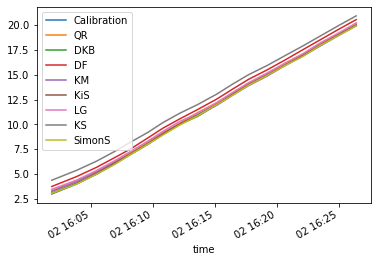

In [13]:
##load the files with the corrected timeaixs and create a dataframe interpolated time of correlation laboratory
##measurement
files = glob.glob(path_timeaxis+"*.LOG")

df1 = calibration.copy()
df1_1 = df1[['time','temperature']].rename(columns={"temperature": "Calibration"})
df1_1['time'] = pd.to_datetime(df1["time"], utc=True).dt.tz_localize(None)
df1 = df1_1.copy()

for count, file in enumerate(files[:]):
    name = file.split("/")[-1].split("_")[-1].split(".")[0]
    df2 = pd.read_csv(file, sep=',', comment='#',names=["time","millis","sensorID","temperature"])
    df2 = df2[["time","temperature"]].rename(columns={"temperature": name})
    df2["time"] = pd.to_datetime(df2["time"], utc=True).dt.tz_localize(None)
    df1_1 = pd.merge_ordered(df1_1, df2)
    
df1_1.set_index(['time'], inplace = True)
df1_1 = (df1_1.interpolate(method = "time")).reindex(df1.time)

df1_1.plot()

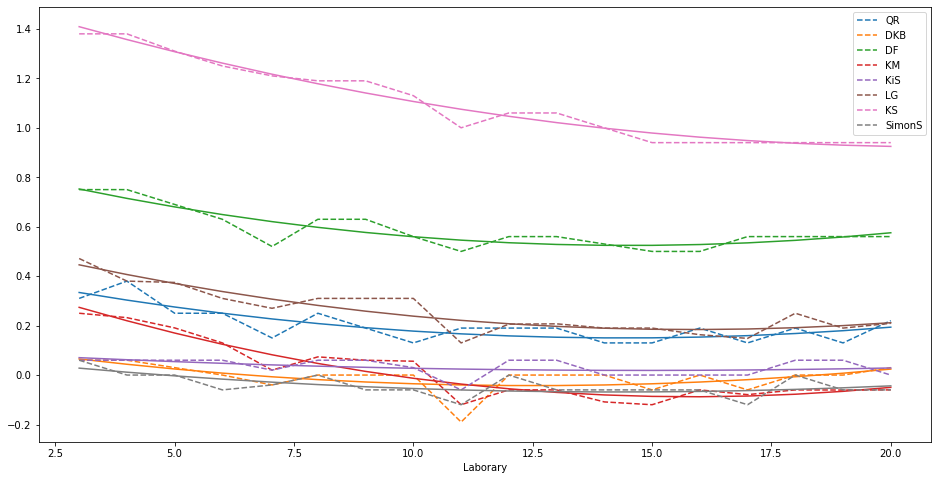

In [14]:
sensor_list = df1_1.columns.values.tolist()[:]

c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',
     '#7f7f7f', '#bcbd22', '#17becf']

#2nd order polnomial fit for calibration
plt.figure(figsize = (16,8))
fit_y = np.zeros((len(sensor_list[1:]),len(df1_1[sensor_list[0]])))
fit_parameter = {} 
for i, sensor in enumerate(sensor_list[1:]):
    fit_parameter[sensor] = np.polyfit(df1_1[sensor_list[0]].values, df1_1[sensor].values-
                                       df1_1[sensor_list[0]].values, 2)
    fit_y[i] = (fit_parameter[sensor][2]+fit_parameter[sensor][1]*df1_1[sensor_list[0]]+
                fit_parameter[sensor][0]*df1_1[sensor_list[0]]**2)
    
    #plot the fit 
    plt.plot(df1_1[sensor_list[0]],fit_y[i])
    plt.plot(df1_1[sensor_list[0]].values,df1_1[sensor].values-df1_1[sensor_list[0]].values,label = sensor,
             alpha = 1,linestyle = "--",c=c[i])  
plt.xlabel("Laborary") 
plt.legend()

#### Calibration of all files

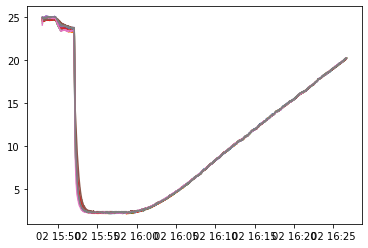

In [15]:
path_storage_calib = path_timeaxis + '/calib/'

k=0
for filename in files:
    #load in all files file by file
    name = filename.split("/")[-1].split("_")[-1].split(".")[0]
    tsensor = pd.read_csv(filename, sep=',', comment='#',names=["time","millis","ID","temperature"])
    tsensor['time'] = pd.to_datetime(tsensor["time"], utc=True).dt.tz_localize(None) 

    #calibration correction of the temperatur
    tsensor['temperature'] = tsensor['temperature'] - (fit_parameter[name][2]+tsensor['temperature']*
                                                       fit_parameter[name][1]+fit_parameter[name][0]*
                                                       tsensor['temperature']**2)
    tsensor.to_csv(path_storage_calib + name + '.LOG', header=None, index=False)
    plt.plot(tsensor['time'], tsensor['temperature'])
    k+=1

### Time constant

['Tsensor_measurements/files_timeaxis//calib/QR.LOG', 'Tsensor_measurements/files_timeaxis//calib/DKB.LOG', 'Tsensor_measurements/files_timeaxis//calib/DF.LOG', 'Tsensor_measurements/files_timeaxis//calib/KM.LOG', 'Tsensor_measurements/files_timeaxis//calib/KiS.LOG', 'Tsensor_measurements/files_timeaxis//calib/LG.LOG', 'Tsensor_measurements/files_timeaxis//calib/KS.LOG', 'Tsensor_measurements/files_timeaxis//calib/SimonS.LOG']


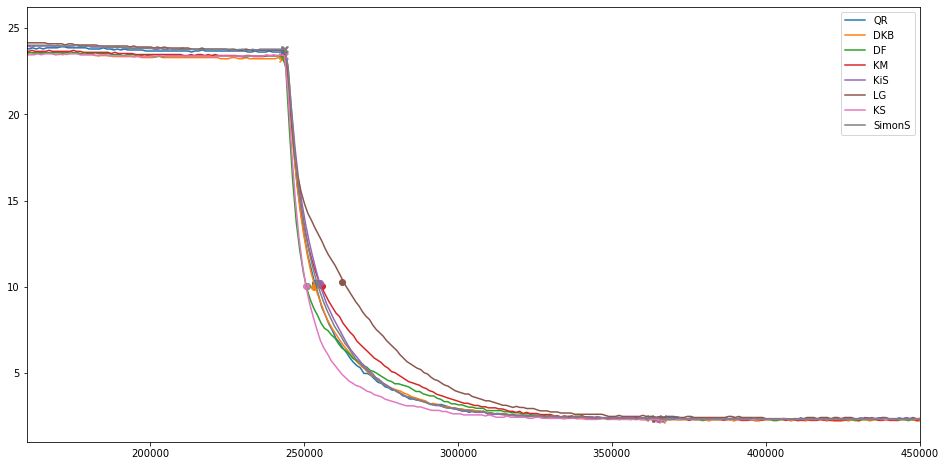

In [16]:
filenames = glob.glob(path_storage_calib+'*.LOG')
print(filenames)

fig=plt.figure(figsize=(16,8))
c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',
              '#7f7f7f', '#bcbd22', '#17becf']
i=0
millis_start = np.zeros(8, int)
for filename in filenames:
    #load in all file by file
    tsensor = pd.read_csv(filename, sep=',', comment='#',names=["time","millis","ID","temperature"])
    
    #calculate temporal changes:
    diff = tsensor['temperature'].values[1:] - tsensor['temperature'].values[:-1]
    
    #find index of value that is closest to 200000ms
    diff_200000 = abs(tsensor['millis']-200000)
    millis_200000 = np.where(diff_200000 == min(diff_200000))[0][0]
    
    #find "start time", where temporal temperature change is larger than 0.1°C
    millis_start[i] = np.where(abs(diff[millis_200000:350]) >= 0.1)[0][0] + millis_200000
    start_time = tsensor['millis'][millis_start[i]]
    #print('millis start: ', millis_start[i])
    
    #find "end time", where temporan temperature change over an interval of 60s is smaller than 0.1°C
    sum_diff = np.zeros(len(diff))
    n= 100 ##average time
    for k in range(len(diff)-n):
        sum_diff[k+n-1] = np.nanmean(diff[k:k+n-1])
    
    millis_end = np.where(abs(sum_diff[millis_start[i]+n:]) <= 0.1)[0][0]
    end_time = tsensor['millis'][millis_start[i]+millis_end+n]  
    #print('end time: ', end_time)
    
    ##find start and end temperature by averaging over 30s:
    temp_start = np.mean(tsensor['temperature'].values[millis_start[i]-30:\
                                                       millis_start[i]+1])
    #print(filename.split("/")[-1].split("_")[-1].split(".")[0] + '   temp start: ', temp_start)
    temp_end = np.mean(tsensor['temperature'].values[millis_start[i]+millis_end+n:\
                                                     millis_start[i]+millis_end+n+31])
    #print(filename.split("/")[-1].split("_")[-1].split(".")[0] + '   temp end: ',temp_end)
    
    ##calculate temperature and time constant
    Temp_tau = temp_end + 1/np.e *(temp_start - temp_end)
    #print(filename.split("/")[-1].split("_")[-1].split(".")[0] + '   Temp tau: ',Temp_tau)
    diff_temp = abs(tsensor['temperature'].values[:330] - Temp_tau)
    time_tau = tsensor['millis'].values[np.where(diff_temp == min(diff_temp))[0][0]]
    #print(filename.split("/")[-1].split("_")[-1].split(".")[0] + '   time tau: ',time_tau)
    
    
    #plot of the sensors:
    plt.plot(tsensor["millis"], tsensor["temperature"], c=c[i], label = filename.split("/")[-1].
             split("_")[-1].split(".")[0])
    plt.scatter(start_time, tsensor['temperature'].values[millis_start[i]],c = c[i], marker='x')
    plt.scatter(end_time, tsensor['temperature'].values[millis_start[i]+millis_end+n], c=c[i],
                marker='x')
    plt.scatter(time_tau, Temp_tau)
    plt.legend()
    plt.xlim(160000,450000)
    
    i += 1